In [1]:
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import pytz
import datetime as dt
import numpy as np
import time

In [18]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '15m'
limit = 1000

# start epoch till now
start_time = 1672556207000
end_time = round(time.time() * 1000)

# step between timestamps in milliseconds
step = 60000 * 15 # 15min

In [19]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        df = pd.concat([df, out], axis = 0)
    
    return df

In [20]:
df = get_historical(symbol, interval, start_time, end_time, step)

# filter columns, adjust data type
df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
df = df.astype(convert_dict)

# adjust time to readable format and adjust timezone
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit = 'ms')
df['Close_Time'] = df['Close_Time'] + pd.Timedelta(hours=timezone)

# set proper index
df = df.reset_index(drop=True)

# for further iterations, to prevent time consumption in fetching raw data 
rawdf = df

print(df)


                        Close_Time     Open    Close     High      Low  \
0    2023-01-01 15:14:59.999000064  1194.81  1194.37  1195.18  1193.63   
1    2023-01-01 15:29:59.999000064  1194.36  1194.60  1194.61  1193.04   
2    2023-01-01 15:44:59.999000064  1194.61  1195.16  1195.17  1193.80   
3    2023-01-01 15:59:59.999000064  1195.16  1195.06  1195.75  1194.61   
4    2023-01-01 16:14:59.999000064  1195.07  1194.51  1195.90  1194.50   
...                            ...      ...      ...      ...      ...   
4326 2023-02-15 16:44:59.999000064  1547.46  1546.41  1549.16  1544.50   
4327 2023-02-15 16:59:59.999000064  1546.41  1546.24  1547.14  1545.63   
4328 2023-02-15 17:14:59.999000064  1546.23  1546.66  1548.50  1546.23   
4329 2023-02-15 17:29:59.999000064  1546.67  1548.57  1548.57  1546.66   
4330 2023-02-15 17:44:59.999000064  1548.56  1548.63  1548.73  1547.79   

         Volume  
0     1675.1834  
1     1522.0955  
2      910.7322  
3     1718.7587  
4     1266.4382  
...

In [30]:
df = rawdf

In [31]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
    return df

In [32]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy,entry_p,stop_loss,position
0,2023-01-01 15:14:59.999000064,1194.81,1194.37,1195.18,1193.63,1675.1834,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,NaN,NaN,NaN
1,2023-01-01 15:29:59.999000064,1194.36,1194.60,1194.61,1193.04,1522.0955,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,NaN,NaN,NaN
2,2023-01-01 15:44:59.999000064,1194.61,1195.16,1195.17,1193.80,910.7322,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,NaN,NaN,NaN
3,2023-01-01 15:59:59.999000064,1195.16,1195.06,1195.75,1194.61,1718.7587,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN
4,2023-01-01 16:14:59.999000064,1195.07,1194.51,1195.90,1194.50,1266.4382,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326,2023-02-15 16:44:59.999000064,1547.46,1546.41,1549.16,1544.50,2803.9568,1548.749333,1552.010274,1548.749333,1545.488393,41.913591,True,True,False,False,False,NaN,NaN,NaN
4327,2023-02-15 16:59:59.999000064,1546.41,1546.24,1547.14,1545.63,1636.6480,1548.620333,1551.960974,1548.620333,1545.279693,41.469037,False,False,False,False,False,NaN,NaN,NaN
4328,2023-02-15 17:14:59.999000064,1546.23,1546.66,1548.50,1546.23,1655.2380,1548.515667,1551.898402,1548.515667,1545.132931,43.075441,False,False,False,False,False,NaN,NaN,NaN
4329,2023-02-15 17:29:59.999000064,1546.67,1548.57,1548.57,1546.66,2025.7889,1548.495667,1551.869775,1548.495667,1545.121559,49.820206,True,False,False,False,False,NaN,NaN,NaN


In [33]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c2 收盤 小於 布林下

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1_1 & df.c1_2 & df.c2 , 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [34]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy,entry_p,stop_loss,position
0,2023-01-01 15:14:59.999000064,1194.81,1194.37,1195.18,1193.63,1675.1834,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,NaN,NaN,NaN
1,2023-01-01 15:29:59.999000064,1194.36,1194.60,1194.61,1193.04,1522.0955,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,NaN,NaN,NaN
2,2023-01-01 15:44:59.999000064,1194.61,1195.16,1195.17,1193.80,910.7322,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,NaN,NaN,NaN
3,2023-01-01 15:59:59.999000064,1195.16,1195.06,1195.75,1194.61,1718.7587,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN
4,2023-01-01 16:14:59.999000064,1195.07,1194.51,1195.90,1194.50,1266.4382,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326,2023-02-15 16:44:59.999000064,1547.46,1546.41,1549.16,1544.50,2803.9568,1548.749333,1552.010274,1548.749333,1545.488393,41.913591,True,True,False,False,False,NaN,NaN,NaN
4327,2023-02-15 16:59:59.999000064,1546.41,1546.24,1547.14,1545.63,1636.6480,1548.620333,1551.960974,1548.620333,1545.279693,41.469037,False,False,False,False,False,NaN,NaN,NaN
4328,2023-02-15 17:14:59.999000064,1546.23,1546.66,1548.50,1546.23,1655.2380,1548.515667,1551.898402,1548.515667,1545.132931,43.075441,False,False,False,False,False,NaN,NaN,NaN
4329,2023-02-15 17:29:59.999000064,1546.67,1548.57,1548.57,1546.66,2025.7889,1548.495667,1551.869775,1548.495667,1545.121559,49.820206,True,False,False,False,False,NaN,NaN,NaN


In [35]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


                        Close_Time     Open    Close     High      Low  \
70   2023-01-02 08:44:59.999000064  1198.17  1198.46  1198.76  1197.50   
71   2023-01-02 08:59:59.999000064  1198.46  1198.16  1198.61  1197.61   
72   2023-01-02 09:14:59.999000064  1198.16  1195.76  1198.31  1194.78   
73   2023-01-02 09:29:59.999000064  1195.75  1196.09  1196.13  1193.00   
74   2023-01-02 09:44:59.999000064  1196.09  1196.03  1196.44  1195.27   
...                            ...      ...      ...      ...      ...   
4138 2023-02-13 17:44:59.999000064  1479.84  1484.21  1485.46  1472.73   
4139 2023-02-13 17:59:59.999000064  1484.21  1482.36  1492.51  1481.72   
4141 2023-02-13 18:29:59.999000064  1481.50  1474.80  1482.76  1466.00   
4142 2023-02-13 18:44:59.999000064  1474.80  1480.80  1480.90  1474.36   
4175 2023-02-14 02:59:59.999000064  1484.71  1488.96  1493.91  1484.56   

          Volume          sma         bb_u         bb_m         bb_l  \
70     1492.0823  1201.488000  1203.976

In [36]:
# 部位回測

posdf = buydf
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

    
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
print(amt_abs_sum)


# 損益
leverage = 10
ttl_profit = -pos.amt.sum()


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)
        
print(ttl_profit, max_entry, profit_per)



                       Close_Time     Open    Close     High      Low  \
0   2023-01-02 08:59:59.999000064  1198.46  1198.16  1198.61  1197.61   
1   2023-01-02 09:14:59.999000064  1198.16  1195.76  1198.31  1194.78   
2   2023-01-02 09:29:59.999000064  1195.75  1196.09  1196.13  1193.00   
3   2023-01-02 09:44:59.999000064  1196.09  1196.03  1196.44  1195.27   
4   2023-01-02 09:59:59.999000064  1196.03  1195.16  1196.03  1195.09   
..                            ...      ...      ...      ...      ...   
110 2023-02-13 06:29:59.999000064  1502.65  1510.03  1512.15  1498.44   
111 2023-02-13 15:29:59.999000064  1520.74  1523.90  1526.10  1520.43   
112 2023-02-13 17:59:59.999000064  1484.21  1482.36  1492.51  1481.72   
113 2023-02-13 18:44:59.999000064  1474.80  1480.80  1480.90  1474.36   
114 2023-02-14 02:59:59.999000064  1484.71  1488.96  1493.91  1484.56   

             sma         bb_u         bb_l        rsi position  entry_p  \
0    1201.397333  1204.152246  1198.642420  38.2

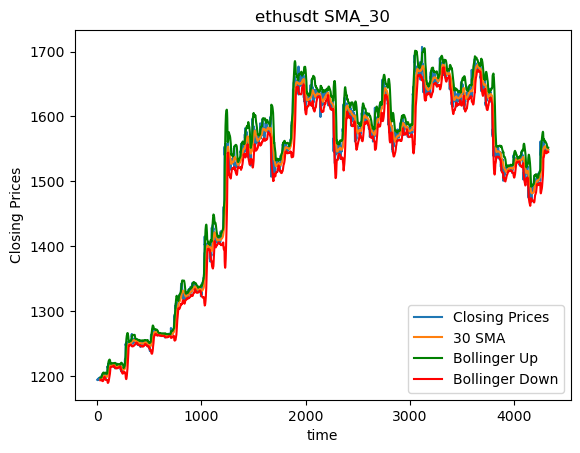

In [37]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()